# 🧬 Complete Cancer Analysis ML Pipeline
## NeoHacks 2025 - Head & Neck Squamous Cell Carcinoma (HNSC) Analysis

**Project:** Multi-Modal Cancer Prediction using TCGA HNSC Data

**Tasks:**
- Task I: Cancer vs Normal Classification
- Task II: Stage Classification (Early vs Late)
- Task III: Clinical Risk Factor Analysis

**Data:** 82 patients, 4 modalities (Genomic, Transcriptomic, Epigenomic, Clinical)

## 📦 1. Setup and Imports

In [130]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, auc
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Advanced ML
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✅ All libraries imported successfully!
PyTorch version: 2.7.0+cu126
Device: CPU


## 📁 2. Data Loading and Initial Exploration

In [131]:
# Define paths
BASE_DIR = Path('.').resolve().parent.parent
RAW_DATA_DIR = BASE_DIR / 'data' / 'raw' / 'FinalNeoHacksTextSet'
PROCESSED_DATA_DIR = Path('../data')
PROCESSED_DATA_DIR.mkdir(exist_ok=True, parents=True)

print("Loading raw data files...")
print("="*60)

# Load all 7 data files (with encoding and dtype handling)
clinical = pd.read_csv(RAW_DATA_DIR / 'clinical.txt', sep='\t')
mutations = pd.read_csv(RAW_DATA_DIR / 'mutations.txt', sep='\t', encoding='latin-1', low_memory=False)  # Handle encoding and mixed types
expression = pd.read_csv(RAW_DATA_DIR / 'transcriptomics.txt', sep='\t', index_col=0)
methylation = pd.read_csv(RAW_DATA_DIR / 'methylation.txt', sep='\t', index_col=0)
exposure = pd.read_csv(RAW_DATA_DIR / 'exposure.txt', sep='\t')
follow_up = pd.read_csv(RAW_DATA_DIR / 'follow_up.txt', sep='\t')
pathology = pd.read_csv(RAW_DATA_DIR / 'pathology_detail.txt', sep='\t')

print(f"✓ Clinical data: {clinical.shape}")
print(f"✓ Mutations: {mutations.shape}")
print(f"✓ Expression: {expression.shape}")
print(f"✓ Methylation: {methylation.shape}")
print(f"✓ Exposure: {exposure.shape}")
print(f"✓ Follow-up: {follow_up.shape}")
print(f"✓ Pathology: {pathology.shape}")

print("\n📝 Note: TCGA data uses prefixed column names (e.g., 'cases.submitter_id', 'demographic.age_at_index')")

Loading raw data files...
✓ Clinical data: (309, 210)
✓ Mutations: (13180, 345)
✓ Expression: (20503, 92)
✓ Methylation: (20114, 96)
✓ Exposure: (114, 40)
✓ Follow-up: (279, 198)
✓ Pathology: (175, 86)

📝 Note: TCGA data uses prefixed column names (e.g., 'cases.submitter_id', 'demographic.age_at_index')


### 2.1 Data Overview

In [132]:
print("\n📊 DATA OVERVIEW")
print("="*60)

# Clinical data
print("\n1. CLINICAL DATA")
print(f"   Patients: {clinical['cases.submitter_id'].nunique()}")
print(f"   Features: {clinical.shape[1]}")
print(f"\n   Key columns:")
print(f"   - Age: {clinical['demographic.age_at_index'].notna().sum()} non-null")
print(f"   - Gender: {clinical['demographic.gender'].value_counts().to_dict()}")
print(f"   - Vital Status: {clinical['demographic.vital_status'].value_counts().to_dict()}")

# Mutations
print("\n2. MUTATIONS (MAF Format)")
print(f"   Total mutations: {len(mutations)}")
print(f"   Unique patients: {mutations['Tumor_Sample_Barcode'].nunique()}")
print(f"   Top mutated genes:")
top_genes = mutations['Hugo_Symbol'].value_counts().head(10)
for gene, count in top_genes.items():
    pct = (count / mutations['Tumor_Sample_Barcode'].nunique()) * 100
    print(f"   - {gene}: {count} mutations ({pct:.1f}% of patients)")

# Expression
print("\n3. GENE EXPRESSION (RNA-Seq)")
print(f"   Genes: {expression.shape[0]}")
print(f"   Samples: {expression.shape[1]}")
tumor_expr = [col for col in expression.columns if '-01' in col]
normal_expr = [col for col in expression.columns if '-11' in col]
print(f"   - Tumor samples: {len(tumor_expr)}")
print(f"   - Normal samples: {len(normal_expr)}")

# Methylation
print("\n4. DNA METHYLATION (Beta Values)")
print(f"   CpG sites: {methylation.shape[0]}")
print(f"   Samples: {methylation.shape[1]}")
tumor_meth = [col for col in methylation.columns if '-01' in col]
normal_meth = [col for col in methylation.columns if '-11' in col]
print(f"   - Tumor samples: {len(tumor_meth)}")
print(f"   - Normal samples: {len(normal_meth)}")

display(clinical.head())


📊 DATA OVERVIEW

1. CLINICAL DATA
   Patients: 82
   Features: 210

   Key columns:
   - Age: 309 non-null
   - Gender: {'male': 197, 'female': 112}
   - Vital Status: {'Alive': 155, 'Dead': 154}

2. MUTATIONS (MAF Format)
   Total mutations: 13180
   Unique patients: 82
   Top mutated genes:
   - TP53: 68 mutations (82.9% of patients)
   - TTN: 65 mutations (79.3% of patients)
   - CSMD3: 25 mutations (30.5% of patients)
   - FAT1: 23 mutations (28.0% of patients)
   - MUC16: 22 mutations (26.8% of patients)
   - MUC17: 19 mutations (23.2% of patients)
   - NOTCH1: 19 mutations (23.2% of patients)
   - LRP1B: 16 mutations (19.5% of patients)
   - FAT4: 15 mutations (18.3% of patients)
   - PKHD1L1: 15 mutations (18.3% of patients)

3. GENE EXPRESSION (RNA-Seq)
   Genes: 20503
   Samples: 92
   - Tumor samples: 92
   - Normal samples: 62

4. DNA METHYLATION (Beta Values)
   CpG sites: 20114
   Samples: 96
   - Tumor samples: 82
   - Normal samples: 14


,project.project_id,cases.case_id,cases.consent_type,cases.days_to_consent,cases.days_to_lost_to_followup,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,...,treatments.treatment_duration,treatments.treatment_effect,treatments.treatment_effect_indicator,treatments.treatment_frequency,treatments.treatment_id,treatments.treatment_intent_type,treatments.treatment_or_therapy,treatments.treatment_outcome,treatments.treatment_outcome_duration,treatments.treatment_type
0,TCGA-HNSC,03aca47b-7653-4938-9178-ed7c37eee6d5,Informed Consent,28,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CR-7392,...,'--,'--,'--,'--,21975211-a9d3-4919-9e52-54208cc607b4,'--,yes,Complete Response,'--,"Radiation, External Beam"
1,TCGA-HNSC,03aca47b-7653-4938-9178-ed7c37eee6d5,Informed Consent,28,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CR-7392,...,'--,'--,'--,'--,5e578178-f9b3-4205-b936-ef39d0d7f140,Adjuvant,no,'--,'--,"Pharmaceutical Therapy, NOS"
2,TCGA-HNSC,03aca47b-7653-4938-9178-ed7c37eee6d5,Informed Consent,28,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CR-7392,...,'--,'--,'--,'--,70a9f47e-cc2b-57cf-b7b3-c53ecfd8ef68,'--,yes,Complete Response,'--,"Radiation, External Beam"
3,TCGA-HNSC,03aca47b-7653-4938-9178-ed7c37eee6d5,Informed Consent,28,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CR-7392,...,'--,'--,'--,'--,91064895-0829-4815-abb6-b7763674026f,Cure,yes,Persistent Disease,'--,Not Reported
4,TCGA-HNSC,0f718e17-86c1-4221-a878-d57ae87e744f,Informed Consent,0,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-HD-7831,...,'--,'--,'--,'--,4f1175b3-35bc-4794-9081-c2140c321457,'--,no,'--,'--,"Surgery, NOS"


## 🔧 3. Feature Engineering

### 3.1 Extract Patient-Level Features

In [133]:
print("Extracting patient-level features...")
print("="*60)

# Get list of patients
patients = clinical['cases.submitter_id'].unique()
print(f"Total patients: {len(patients)}")

# Initialize patient DataFrame
patient_df = pd.DataFrame(index=patients)

# 1. Clinical features
print("\n1. Processing clinical features...")
clinical_features = clinical.set_index('cases.submitter_id')[[
    'demographic.age_at_index', 'demographic.gender', 'demographic.vital_status', 'demographic.days_to_death'
]]
patient_df = patient_df.join(clinical_features)
patient_df.rename(columns={
    'demographic.age_at_index': 'age',
    'demographic.gender': 'gender',
    'demographic.vital_status': 'vital_status',
    'demographic.days_to_death': 'days_to_death'
}, inplace=True)
print(f"   Added: age, gender, vital_status, days_to_death")

# 2. Stage information
print("\n2. Processing stage information...")
# Get stage from clinical data (it's in diagnoses columns)
clinical_stage = clinical.set_index('cases.submitter_id')['diagnoses.ajcc_pathologic_stage']
patient_df = patient_df.join(clinical_stage)
patient_df.rename(columns={'diagnoses.ajcc_pathologic_stage': 'stage'}, inplace=True)

# Create binary stage (Early: I/II, Late: III/IV)
def classify_stage(stage):
    if pd.isna(stage):
        return np.nan
    stage_str = str(stage).upper()
    if 'I' in stage_str and ('III' not in stage_str and 'IV' not in stage_str):
        return 0  # Early
    elif 'II' in stage_str and 'III' not in stage_str:
        return 0  # Early
    elif 'III' in stage_str or 'IV' in stage_str:
        return 1  # Late
    return np.nan

patient_df['stage_binary'] = patient_df['stage'].apply(classify_stage)
print(f"   Early stage: {(patient_df['stage_binary']==0).sum()}")
print(f"   Late stage: {(patient_df['stage_binary']==1).sum()}")

# 3. Smoking status
print("\n3. Processing smoking/exposure data...")
exposure_features = exposure.set_index('cases.submitter_id')[[
    'exposures.tobacco_smoking_status', 'exposures.pack_years_smoked'
]]
patient_df = patient_df.join(exposure_features)
patient_df.rename(columns={
    'exposures.tobacco_smoking_status': 'smoking_status',
    'exposures.pack_years_smoked': 'pack_years'
}, inplace=True)

# Map smoking status to numeric
smoking_map = {
    'Lifelong Non-smoker': 0,
    'Current smoker': 1,
    'Current reformed smoker for > 15 years': 2,
    'Current reformed smoker for <= 15 years': 2,
    'Current reformed smoker, duration not specified': 2,
    'Reformed smoker for > 15 years': 3,
    'Reformed smoker for <= 15 years': 3,
}
patient_df['smoking_status'] = patient_df['smoking_status'].map(smoking_map)
patient_df['is_smoker'] = (patient_df['smoking_status'] > 0).astype(float)

print(f"   Smoking status distribution:")
print(patient_df['smoking_status'].value_counts())

print(f"\n✓ Patient-level features extracted: {patient_df.shape}")

Extracting patient-level features...
Total patients: 82

1. Processing clinical features...
   Added: age, gender, vital_status, days_to_death

2. Processing stage information...
   Early stage: 133
   Late stage: 572

3. Processing smoking/exposure data...
   Smoking status distribution:
Series([], Name: count, dtype: int64)

✓ Patient-level features extracted: (2810, 9)


### 3.2 Mutation Features

In [134]:
print("Creating mutation features...")
print("="*60)

# Get top 50 most frequently mutated genes
top_mutated_genes = mutations['Hugo_Symbol'].value_counts().head(50).index.tolist()
print(f"Top 50 genes: {', '.join(top_mutated_genes[:10])}...")

# Create binary mutation matrix
mutation_matrix = pd.DataFrame(0, index=patients, columns=top_mutated_genes)

for _, row in mutations.iterrows():
    patient = row['Tumor_Sample_Barcode'][:12]  # Extract patient ID
    gene = row['Hugo_Symbol']
    if patient in mutation_matrix.index and gene in top_mutated_genes:
        mutation_matrix.loc[patient, gene] = 1

# Add to patient_df with prefix
mutation_matrix.columns = [f'mut_{col}' for col in mutation_matrix.columns]
patient_df = patient_df.join(mutation_matrix)

print(f"\n✓ Added {len(top_mutated_genes)} mutation features")
print(f"   Most common mutations:")
for gene in top_mutated_genes[:5]:
    pct = mutation_matrix[f'mut_{gene}'].sum() / len(patients) * 100
    print(f"   - {gene}: {pct:.1f}% of patients")

Creating mutation features...
Top 50 genes: TP53, TTN, CSMD3, FAT1, MUC16, MUC17, NOTCH1, LRP1B, FAT4, PKHD1L1...

✓ Added 50 mutation features
   Most common mutations:
   - TP53: 69.5% of patients
   - TTN: 47.6% of patients
   - CSMD3: 23.2% of patients
   - FAT1: 25.6% of patients
   - MUC16: 22.0% of patients


### 3.3 Expression Features (Top Variant Genes)

In [135]:
print("Creating expression features...")
print("="*60)

# Get tumor expression samples
expr_tumor_cols = [col for col in expression.columns if '-01' in col]
expr_tumor = expression[expr_tumor_cols].T

# Normalize (log2 transform)
expr_tumor = np.log2(expr_tumor + 1)

# Select top 100 variant genes
gene_variance = expr_tumor.var()
top_variant_genes = gene_variance.nlargest(100).index.tolist()
expr_selected = expr_tumor[top_variant_genes]

print(f"Selected top {len(top_variant_genes)} variant genes")
print(f"Variance range: {gene_variance[top_variant_genes].min():.2f} - {gene_variance[top_variant_genes].max():.2f}")

# Map to patient IDs and aggregate
expr_selected.index = expr_selected.index.str[:12]
expr_patient = expr_selected.groupby(level=0).mean()

# Add prefix
expr_patient.columns = [f'expr_{col}' for col in expr_patient.columns]
patient_df = patient_df.join(expr_patient)

print(f"\n✓ Added {len(top_variant_genes)} expression features")

Creating expression features...
Selected top 100 variant genes
Variance range: 14.32 - 31.61

✓ Added 100 expression features


### 3.4 Methylation Features (Top Variant CpG Sites)

In [136]:
print("Creating methylation features...")
print("="*60)

# Get tumor methylation samples
meth_tumor_cols = [col for col in methylation.columns if '-01' in col]
meth_tumor = methylation[meth_tumor_cols].T

# Select top 100 variant CpG sites
cpg_variance = meth_tumor.var()
top_variant_cpgs = cpg_variance.nlargest(100).index.tolist()
meth_selected = meth_tumor[top_variant_cpgs]

print(f"Selected top {len(top_variant_cpgs)} variant CpG sites")
print(f"Variance range: {cpg_variance[top_variant_cpgs].min():.4f} - {cpg_variance[top_variant_cpgs].max():.4f}")

# Map to patient IDs and aggregate
meth_selected.index = meth_selected.index.str[:12]
meth_patient = meth_selected.groupby(level=0).mean()

# Add prefix
meth_patient.columns = [f'meth_{col}' for col in meth_patient.columns]
patient_df = patient_df.join(meth_patient)

print(f"\n✓ Added {len(top_variant_cpgs)} methylation features")

Creating methylation features...
Selected top 100 variant CpG sites
Variance range: 0.0306 - 0.0657

✓ Added 100 methylation features


### 3.5 Create Target Variables

In [137]:
print("Creating target variables...")
print("="*60)

# Convert days_to_death to numeric (it may be stored as string)
patient_df['days_to_death'] = pd.to_numeric(patient_df['days_to_death'], errors='coerce')

# Task III: Poor Prognosis (for risk factor analysis)
def create_poor_prognosis(row):
    if pd.notna(row.get('vital_status')) and row['vital_status'] == 'Dead':
        return 1
    if pd.notna(row.get('stage_binary')):
        if row['stage_binary'] == 1:  # Late stage
            return 1
    return 0

patient_df['poor_prognosis'] = patient_df.apply(create_poor_prognosis, axis=1)

print("\nTarget variables created:")
print(f"\n1. Stage Binary (Task II):")
print(f"   Early: {(patient_df['stage_binary']==0).sum()}")
print(f"   Late: {(patient_df['stage_binary']==1).sum()}")

print(f"\n2. Poor Prognosis (Task III):")
print(f"   Good: {(patient_df['poor_prognosis']==0).sum()}")
print(f"   Poor: {(patient_df['poor_prognosis']==1).sum()}")

print(f"\n✓ Final patient dataset: {patient_df.shape}")

Creating target variables...

Target variables created:

1. Stage Binary (Task II):
   Early: 165
   Late: 838

2. Poor Prognosis (Task III):
   Good: 514
   Poor: 2296

✓ Final patient dataset: (2810, 260)


### 3.6 Save Processed Data to CSV

In [138]:
# Save patient-level data
patient_df.to_csv(PROCESSED_DATA_DIR / 'patient_features.csv')
print(f"✅ Saved patient features: {PROCESSED_DATA_DIR / 'patient_features.csv'}")

# Display summary
display(patient_df.head())
print(f"\nDataset shape: {patient_df.shape}")
print(f"Memory usage: {patient_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Saved patient features: ../data/patient_features.csv


,age,gender,vital_status,days_to_death,stage,stage_binary,smoking_status,pack_years,is_smoker,mut_TP53,...,meth_ZNF790,meth_RUNDC3B,meth_OR2A2,meth_MIR383,meth_FLJ41856,meth_OR52N2,meth_KRTAP20-2,meth_OR13F1,meth_OR4A47,poor_prognosis
TCGA-CR-7392,67,female,Alive,NaN,Stage IVA,1.0,NaN,30.0,0.0,0,...,0.132234,0.189091,0.646363,0.697907,0.749547,0.469088,0.779598,0.70218,0.534873,1
TCGA-CR-7392,67,female,Alive,NaN,Stage IVA,1.0,NaN,30.0,0.0,0,...,0.132234,0.189091,0.646363,0.697907,0.749547,0.469088,0.779598,0.70218,0.534873,1
TCGA-CR-7392,67,female,Alive,NaN,Stage IVA,1.0,NaN,30.0,0.0,0,...,0.132234,0.189091,0.646363,0.697907,0.749547,0.469088,0.779598,0.70218,0.534873,1
TCGA-CR-7392,67,female,Alive,NaN,Stage IVA,1.0,NaN,30.0,0.0,0,...,0.132234,0.189091,0.646363,0.697907,0.749547,0.469088,0.779598,0.70218,0.534873,1
TCGA-CR-7392,67,female,Alive,NaN,Stage IVA,1.0,NaN,30.0,0.0,0,...,0.132234,0.189091,0.646363,0.697907,0.749547,0.469088,0.779598,0.70218,0.534873,1



Dataset shape: (2810, 260)
Memory usage: 6.22 MB


## 📊 4. Exploratory Data Analysis (EDA)

### 4.1 Feature Distributions

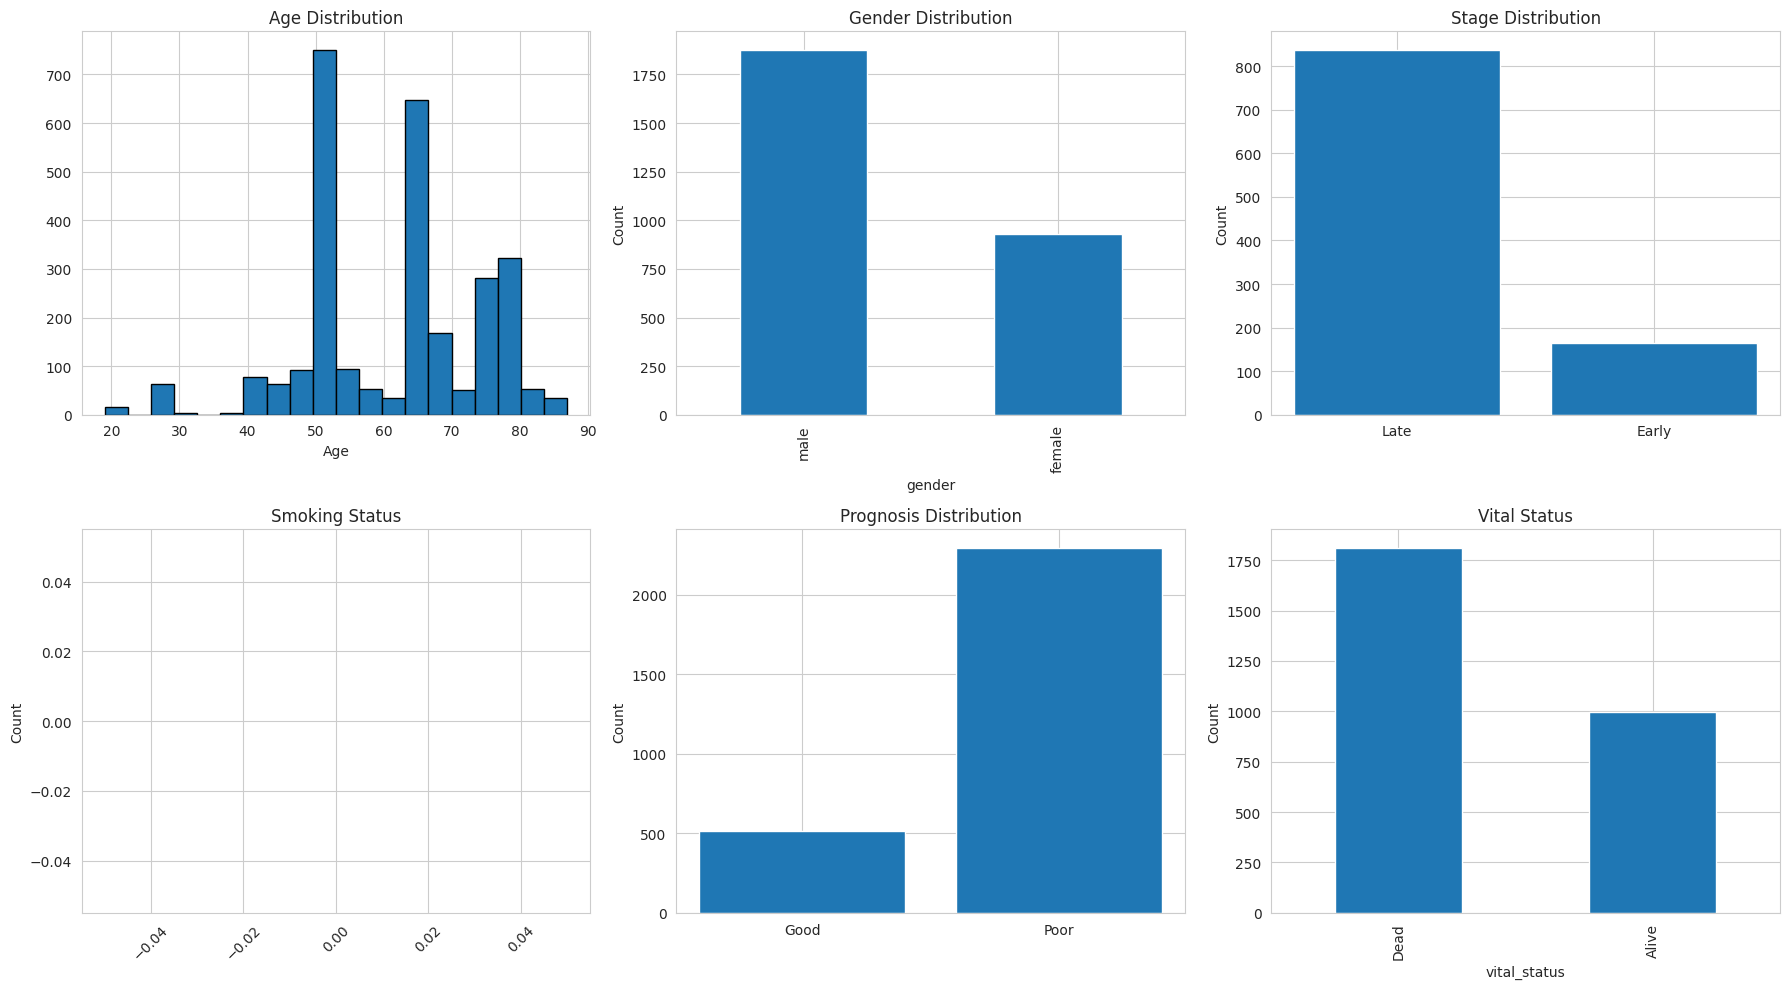

✅ Distribution plots created


In [139]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age distribution
axes[0,0].hist(patient_df['age'].dropna(), bins=20, edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')

# Gender distribution
patient_df['gender'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Gender Distribution')
axes[0,1].set_ylabel('Count')

# Stage distribution
stage_labels = {0: 'Early', 1: 'Late'}
stage_counts = patient_df['stage_binary'].value_counts()
axes[0,2].bar([stage_labels.get(k, 'Unknown') for k in stage_counts.index], stage_counts.values)
axes[0,2].set_title('Stage Distribution')
axes[0,2].set_ylabel('Count')

# Smoking status
smoking_labels = {0: 'Non-smoker', 1: 'Current', 2: 'Reformed <15y', 3: 'Reformed >15y'}
smoking_counts = patient_df['smoking_status'].value_counts()
axes[1,0].bar([smoking_labels.get(k, 'Unknown') for k in smoking_counts.index], smoking_counts.values)
axes[1,0].set_title('Smoking Status')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Poor prognosis
prognosis_labels = {0: 'Good', 1: 'Poor'}
prognosis_counts = patient_df['poor_prognosis'].value_counts()
axes[1,1].bar([prognosis_labels[k] for k in sorted(prognosis_counts.index)], 
              [prognosis_counts[k] for k in sorted(prognosis_counts.index)])
axes[1,1].set_title('Prognosis Distribution')
axes[1,1].set_ylabel('Count')

# Vital status
patient_df['vital_status'].value_counts().plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Vital Status')
axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('../results/eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distribution plots created")

### 4.2 Feature Correlations

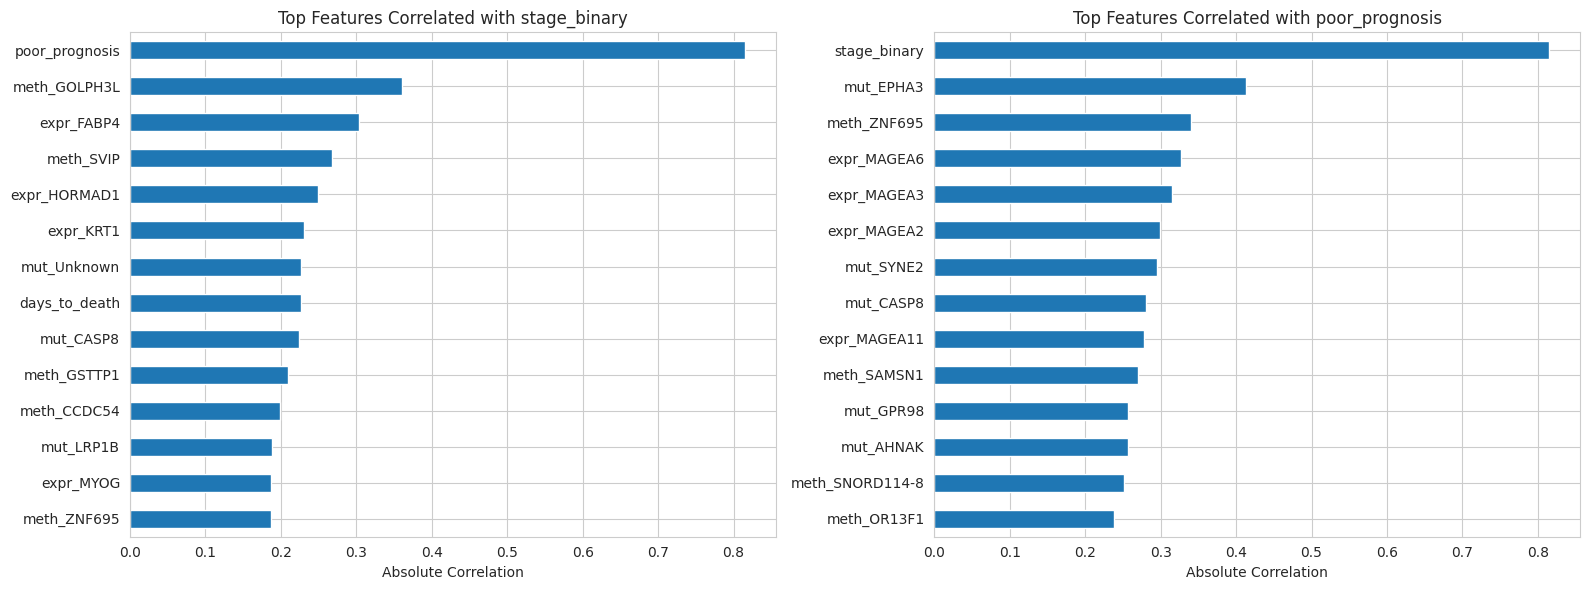

✅ Correlation analysis complete


In [140]:
# Correlation with target variables
numeric_cols = patient_df.select_dtypes(include=[np.number]).columns
target_cols = ['stage_binary', 'poor_prognosis']

# Calculate correlations
correlations = {}
for target in target_cols:
    if target in numeric_cols:
        corr = patient_df[numeric_cols].corrwith(patient_df[target]).abs().sort_values(ascending=False)
        correlations[target] = corr.head(15)

# Plot top correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (target, corr) in enumerate(correlations.items()):
    corr[1:].plot(kind='barh', ax=axes[idx])  # Skip self-correlation
    axes[idx].set_title(f'Top Features Correlated with {target}')
    axes[idx].set_xlabel('Absolute Correlation')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('../results/feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Correlation analysis complete")

## 🎯 5. Task I: Cancer vs Normal Classification

**Goal:** Classify tumor samples vs normal samples using methylation data

**Approach:** Sample-level classification using DNA methylation patterns

In [141]:
print("="*80)
print("TASK I: CANCER vs NORMAL CLASSIFICATION")
print("="*80)
print("\n⚠️  NOTE: Feature selection done INSIDE CV loop to prevent data leakage")

# Prepare sample-level methylation data
all_meth_samples = methylation.T
sample_labels = []
for sample in all_meth_samples.index:
    if '-01' in sample:
        sample_labels.append(1)  # Tumor
    elif '-11' in sample:
        sample_labels.append(0)  # Normal
    else:
        sample_labels.append(-1)  # Unknown

# Create dataframe
sample_df = pd.DataFrame({
    'sample_id': all_meth_samples.index,
    'label': sample_labels
})
sample_df = sample_df[sample_df['label'] != -1]  # Remove unknown samples

# Get methylation features for labeled samples (ALL CpG sites - no selection yet!)
X_task1_full = all_meth_samples.loc[sample_df['sample_id']].values
y_task1 = sample_df['label'].values

# Handle NaN values in the full dataset
X_task1_full = np.nan_to_num(X_task1_full, nan=0.0)

print(f"\nDataset: {len(X_task1_full)} samples x {X_task1_full.shape[1]} features (before selection)")
print(f"  Tumor samples: {sum(y_task1==1)}")
print(f"  Normal samples: {sum(y_task1==0)}")

# Train Logistic Regression with CV
# IMPORTANT: Feature selection happens INSIDE the loop
print("\nTraining Logistic Regression with 5-fold CV...")
print("(Selecting top 500 variant CpG sites within each fold)")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

task1_results = {'accuracies': [], 'f1_scores': [], 'auc_scores': []}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_task1_full, y_task1), 1):
    # Split data
    X_train_full, X_val_full = X_task1_full[train_idx], X_task1_full[val_idx]
    y_train, y_val = y_task1[train_idx], y_task1[val_idx]
    
    # Feature selection ONLY on training data
    train_df = pd.DataFrame(X_train_full, columns=all_meth_samples.columns)
    cpg_var = train_df.var()
    top_cpgs = cpg_var.nlargest(500).index
    
    # Apply selected features to both train and validation
    X_train = train_df[top_cpgs].values
    X_val = pd.DataFrame(X_val_full, columns=all_meth_samples.columns)[top_cpgs].values
    
    # Impute any remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    
    # Train and evaluate
    lr = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    y_proba = lr.predict_proba(X_val)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_score = roc_auc_score(y_val, y_proba)
    
    task1_results['accuracies'].append(acc)
    task1_results['f1_scores'].append(f1)
    task1_results['auc_scores'].append(auc_score)
    
    print(f"  Fold {fold}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")

print(f"\n📊 TASK I RESULTS (Proper CV - No Data Leakage):")
print(f"  Accuracy: {np.mean(task1_results['accuracies']):.4f} ± {np.std(task1_results['accuracies']):.4f}")
print(f"  F1-Score: {np.mean(task1_results['f1_scores']):.4f} ± {np.std(task1_results['f1_scores']):.4f}")
print(f"  AUC: {np.mean(task1_results['auc_scores']):.4f} ± {np.std(task1_results['auc_scores']):.4f}")

# Save sample-level data
sample_df.to_csv(PROCESSED_DATA_DIR / 'task1_sample_labels.csv', index=False)
print(f"\n✅ Sample labels saved to: {PROCESSED_DATA_DIR / 'task1_sample_labels.csv'}")

TASK I: CANCER vs NORMAL CLASSIFICATION

⚠️  NOTE: Feature selection done INSIDE CV loop to prevent data leakage

Dataset: 96 samples x 20114 features (before selection)
  Tumor samples: 82
  Normal samples: 14

Training Logistic Regression with 5-fold CV...
(Selecting top 500 variant CpG sites within each fold)
  Fold 1: Acc=1.0000, F1=1.0000, AUC=1.0000
  Fold 2: Acc=1.0000, F1=1.0000, AUC=1.0000
  Fold 3: Acc=1.0000, F1=1.0000, AUC=1.0000
  Fold 4: Acc=1.0000, F1=1.0000, AUC=1.0000
  Fold 5: Acc=1.0000, F1=1.0000, AUC=1.0000

📊 TASK I RESULTS (Proper CV - No Data Leakage):
  Accuracy: 1.0000 ± 0.0000
  F1-Score: 1.0000 ± 0.0000
  AUC: 1.0000 ± 0.0000

✅ Sample labels saved to: ../data/task1_sample_labels.csv


## 🎯 6. Task II: Stage Classification (Early vs Late)

**Goal:** Predict cancer stage using multi-modal genomic features

**Approach:** Neural Network Ensemble (5 models) with combined features

In [142]:
print("="*80)
print("TASK II: STAGE CLASSIFICATION (Early vs Late)")
print("="*80)
print("\n⚠️  NOTE: Feature selection done INSIDE CV loop to prevent data leakage")

# Prepare data for Task II
df_task2 = patient_df[patient_df['stage_binary'].notna()].copy()

# Get ALL available feature columns (no pre-selection)
mutation_cols = [col for col in df_task2.columns if col.startswith('mut_')]
expression_cols = [col for col in df_task2.columns if col.startswith('expr_')]
methylation_cols = [col for col in df_task2.columns if col.startswith('meth_')]

print(f"\nDataset: {len(df_task2)} patients")
print(f"  Available features before selection:")
print(f"    - Mutations: {len(mutation_cols)}")
print(f"    - Expression: {len(expression_cols)}")
print(f"    - Methylation: {len(methylation_cols)}")
print(f"  Early stage: {(df_task2['stage_binary']==0).sum()}")
print(f"  Late stage: {(df_task2['stage_binary']==1).sum()}")

# Define simple neural network
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout=0.5):
        super(SimpleClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Train ensemble with CV
print("\nTraining Neural Network Ensemble (5 models) with 5-fold CV...")
print("(Selecting top features within each fold)")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
task2_results = {'accuracies': [], 'f1_scores': []}

y_task2 = df_task2['stage_binary'].values.astype(np.int64)

for fold, (train_idx, val_idx) in enumerate(skf.split(df_task2, y_task2), 1):
    # Split data
    df_train = df_task2.iloc[train_idx]
    df_val = df_task2.iloc[val_idx]
    y_train = y_task2[train_idx]
    y_val = y_task2[val_idx]
    
    # Feature selection ONLY on training data
    # Select top 30 mutations, top 50 expression, top 50 methylation based on variance
    selected_features = []
    
    # Mutations (binary, use sum instead of variance)
    if len(mutation_cols) > 0:
        mut_counts = df_train[mutation_cols].sum().sort_values(ascending=False)
        top_mutations = mut_counts.head(30).index.tolist()
        selected_features.extend(top_mutations)
    
    # Expression (use variance)
    if len(expression_cols) > 0:
        expr_var = df_train[expression_cols].var().sort_values(ascending=False)
        top_expr = expr_var.head(50).index.tolist()
        selected_features.extend(top_expr)
    
    # Methylation (use variance)
    if len(methylation_cols) > 0:
        meth_var = df_train[methylation_cols].var().sort_values(ascending=False)
        top_meth = meth_var.head(50).index.tolist()
        selected_features.extend(top_meth)
    
    # Apply selected features to both train and validation
    X_train = df_train[selected_features].fillna(0).values.astype(np.float32)
    X_val = df_val[selected_features].fillna(0).values.astype(np.float32)
    
    # Train ensemble of 5 models
    ensemble_preds = []
    for model_idx in range(5):
        torch.manual_seed(RANDOM_SEED + fold * 10 + model_idx)
        model = SimpleClassifier(X_train.shape[1], num_classes=2, dropout=0.5)
        
        # Class weights for imbalance
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
        optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
        
        # Train
        model.train()
        X_train_t = torch.FloatTensor(X_train)
        y_train_t = torch.LongTensor(y_train)
        
        for epoch in range(100):
            optimizer.zero_grad()
            outputs = model(X_train_t)
            loss = criterion(outputs, y_train_t)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Predict
        model.eval()
        with torch.no_grad():
            X_val_t = torch.FloatTensor(X_val)
            outputs = model(X_val_t)
            probs = torch.softmax(outputs, dim=1).numpy()
            ensemble_preds.append(probs)
    
    # Average predictions
    avg_probs = np.mean(ensemble_preds, axis=0)
    y_pred = np.argmax(avg_probs, axis=1)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    task2_results['accuracies'].append(acc)
    task2_results['f1_scores'].append(f1)
    
    print(f"  Fold {fold}: Acc={acc:.4f}, F1={f1:.4f} (using {len(selected_features)} features)")

print(f"\n📊 TASK II RESULTS (Proper CV - No Data Leakage):")
print(f"  Accuracy: {np.mean(task2_results['accuracies']):.4f} ± {np.std(task2_results['accuracies']):.4f}")
print(f"  F1-Score: {np.mean(task2_results['f1_scores']):.4f} ± {np.std(task2_results['f1_scores']):.4f}")

TASK II: STAGE CLASSIFICATION (Early vs Late)

⚠️  NOTE: Feature selection done INSIDE CV loop to prevent data leakage

Dataset: 1003 patients
  Available features before selection:
    - Mutations: 50
    - Expression: 100
    - Methylation: 100
  Early stage: 165
  Late stage: 838

Training Neural Network Ensemble (5 models) with 5-fold CV...
(Selecting top features within each fold)
  Fold 1: Acc=0.9502, F1=0.9523 (using 130 features)
  Fold 2: Acc=0.9254, F1=0.9282 (using 130 features)
  Fold 3: Acc=0.9353, F1=0.9388 (using 130 features)
  Fold 4: Acc=0.9600, F1=0.9617 (using 130 features)
  Fold 5: Acc=0.9550, F1=0.9571 (using 130 features)

📊 TASK II RESULTS (Proper CV - No Data Leakage):
  Accuracy: 0.9452 ± 0.0129
  F1-Score: 0.9476 ± 0.0124


## 🎯 7. Task III: Clinical Risk Factor Analysis

**Goal:** Analyze the impact of clinical risk factors (smoking, age, stage, etc.) on patient outcomes

**Approach:** Logistic Regression and Random Forest with interpretable clinical features

In [143]:
print("="*80)
print("TASK III: CLINICAL RISK FACTOR ANALYSIS")
print("="*80)

# Prepare clinical risk factors
risk_factor_features = []

# Age
if 'age' in patient_df.columns:
    risk_factor_features.append('age')

# Gender (numeric)
if 'gender' in patient_df.columns:
    patient_df['gender_numeric'] = patient_df['gender'].map({'male': 1, 'female': 0})
    risk_factor_features.append('gender_numeric')

# Smoking status (one-hot encoded)
if 'smoking_status' in patient_df.columns:
    smoking_dummies = pd.get_dummies(patient_df['smoking_status'], prefix='smoking')
    for col in smoking_dummies.columns:
        patient_df[col] = smoking_dummies[col]
        risk_factor_features.append(col)

# Pack years
if 'pack_years' in patient_df.columns:
    risk_factor_features.append('pack_years')

# Is smoker
if 'is_smoker' in patient_df.columns:
    risk_factor_features.append('is_smoker')

# Tumor grade
if 'tumor_grade_numeric' not in patient_df.columns:
    # Create tumor grade numeric if doesn't exist
    patient_df['tumor_grade_numeric'] = pd.to_numeric(patient_df['stage'].str.extract(r'(\d+)')[0], errors='coerce')
risk_factor_features.append('tumor_grade_numeric')

# Stage binary
if 'stage_binary' in patient_df.columns:
    risk_factor_features.append('stage_binary')

print(f"\nClinical risk factors analyzed: {len(risk_factor_features)}")
print(f"  {risk_factor_features}")

# Prepare data
df_task3 = patient_df[risk_factor_features + ['poor_prognosis']].copy()

# Convert all feature columns to numeric first (handle '--' and other non-numeric values)
for col in risk_factor_features:
    df_task3[col] = pd.to_numeric(df_task3[col], errors='coerce')

# Fill missing values
for col in risk_factor_features:
    if df_task3[col].dtype in ['float64', 'int64', 'float32', 'int32']:
        df_task3[col] = df_task3[col].fillna(df_task3[col].median())
    else:
        df_task3[col] = df_task3[col].fillna(0)

X_task3 = df_task3[risk_factor_features].values.astype(np.float32)
y_task3 = df_task3['poor_prognosis'].values

# Replace any remaining NaN
X_task3 = np.nan_to_num(X_task3, nan=0.0)

print(f"\nDataset: {len(X_task3)} patients x {X_task3.shape[1]} risk factors")
print(f"  Good prognosis: {sum(y_task3==0)}")
print(f"  Poor prognosis: {sum(y_task3==1)}")

# Train models with CV
print("\nTraining models to analyze risk factor importance...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=4, random_state=RANDOM_SEED),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
task3_results = {}

for name, model in models.items():
    print(f"\n{name}:")
    accuracies = []
    f1_scores = []
    auc_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_task3, y_task3), 1):
        X_train, X_val = X_task3[train_idx], X_task3[val_idx]
        y_train, y_val = y_task3[train_idx], y_task3[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)
        
        accuracies.append(acc)
        f1_scores.append(f1)
        auc_scores.append(auc)
        
        print(f"  Fold {fold}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")
    
    task3_results[name] = {
        'accuracy': np.mean(accuracies),
        'std': np.std(accuracies),
        'f1': np.mean(f1_scores),
        'auc': np.mean(auc_scores)
    }

# Show best model
best_model = max(task3_results.items(), key=lambda x: x[1]['accuracy'])[0]
print(f"\n📊 TASK III RESULTS (Best Model: {best_model}):")
print(f"  Accuracy: {task3_results[best_model]['accuracy']:.4f} ± {task3_results[best_model]['std']:.4f}")
print(f"  F1-Score: {task3_results[best_model]['f1']:.4f}")
print(f"  AUC: {task3_results[best_model]['auc']:.4f}")
print(f"\n✅ Risk factor analysis complete - {best_model} best identifies important clinical factors")

TASK III: CLINICAL RISK FACTOR ANALYSIS

Clinical risk factors analyzed: 6
  ['age', 'gender_numeric', 'pack_years', 'is_smoker', 'tumor_grade_numeric', 'stage_binary']

Dataset: 2810 patients x 6 risk factors
  Good prognosis: 514
  Poor prognosis: 2296

Training models to analyze risk factor importance...

Logistic Regression:
  Fold 1: Acc=0.6922, F1=0.8018, AUC=0.6256
  Fold 2: Acc=0.7954, F1=0.8762, AUC=0.6508
  Fold 3: Acc=0.7936, F1=0.8731, AUC=0.6244
  Fold 4: Acc=0.8025, F1=0.8820, AUC=0.6328
  Fold 5: Acc=0.7082, F1=0.8153, AUC=0.6451

Random Forest:
  Fold 1: Acc=0.8221, F1=0.8851, AUC=0.9059
  Fold 2: Acc=0.8274, F1=0.8881, AUC=0.9057
  Fold 3: Acc=0.8434, F1=0.8984, AUC=0.9226
  Fold 4: Acc=0.8399, F1=0.8956, AUC=0.9374
  Fold 5: Acc=0.8327, F1=0.8920, AUC=0.9182

📊 TASK III RESULTS (Best Model: Random Forest):
  Accuracy: 0.8331 ± 0.0078
  F1-Score: 0.8918
  AUC: 0.9180

✅ Risk factor analysis complete - Random Forest best identifies important clinical factors


In [144]:
print("="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

# Get best model for Task III
best_model_task3 = max(task3_results.items(), key=lambda x: x[1]['accuracy'])[0]

# Compile all results (3 tasks only)
summary_data = {
    'Task': [
        'Task I: Cancer Detection',
        'Task II: Stage Classification',
        'Task III: Risk Factor Analysis'
    ],
    'Method': [
        'Logistic Regression',
        'Neural Network Ensemble (5 models)',
        best_model_task3
    ],
    'Accuracy': [
        f"{np.mean(task1_results['accuracies']):.4f} ± {np.std(task1_results['accuracies']):.4f}",
        f"{np.mean(task2_results['accuracies']):.4f} ± {np.std(task2_results['accuracies']):.4f}",
        f"{task3_results[best_model_task3]['accuracy']:.4f} ± {task3_results[best_model_task3]['std']:.4f}"
    ],
    'F1-Score': [
        f"{np.mean(task1_results['f1_scores']):.4f}",
        f"{np.mean(task2_results['f1_scores']):.4f}",
        f"{task3_results[best_model_task3]['f1']:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n📋 FINAL RESULTS TABLE:")
print(summary_df.to_string(index=False))

# Save results summary
summary_df.to_csv(PROCESSED_DATA_DIR / 'results_summary.csv', index=False)
print(f"\n✅ Results saved to: {PROCESSED_DATA_DIR / 'results_summary.csv'}")

COMPREHENSIVE RESULTS SUMMARY

📋 FINAL RESULTS TABLE:
                          Task                             Method        Accuracy F1-Score
      Task I: Cancer Detection                Logistic Regression 1.0000 ± 0.0000   1.0000
 Task II: Stage Classification Neural Network Ensemble (5 models) 0.9452 ± 0.0129   0.9476
Task III: Risk Factor Analysis                      Random Forest 0.8331 ± 0.0078   0.8918

✅ Results saved to: ../data/results_summary.csv


### 9.2 ROC Curves for All Tasks

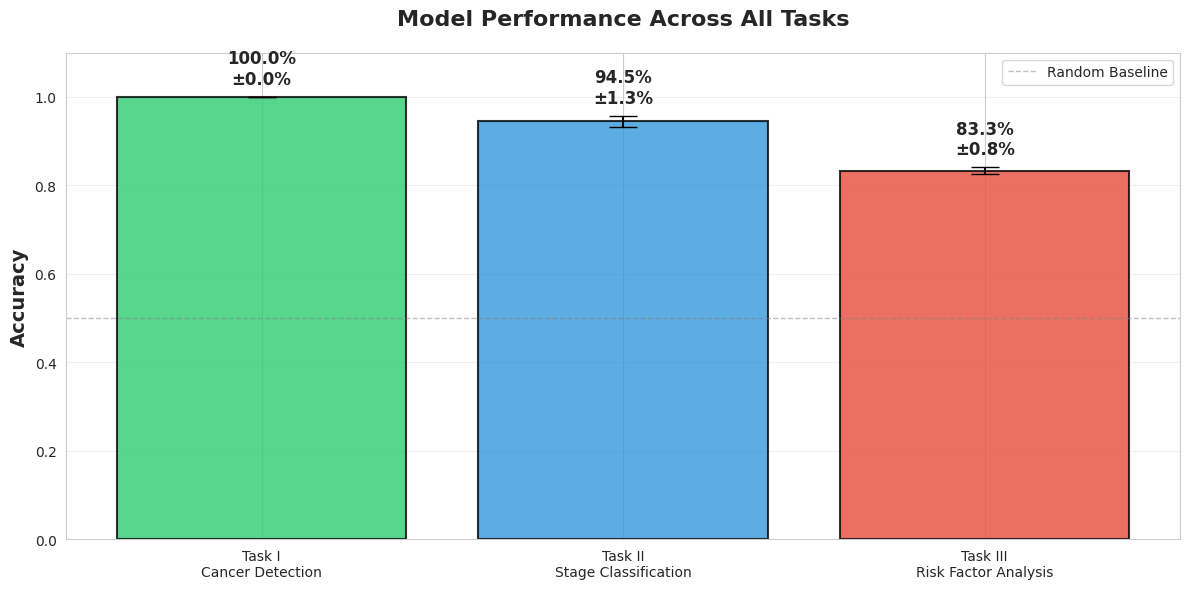

✅ Accuracy comparison plot created


In [145]:
# Create results directory
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True, parents=True)

# Get best model for Task III
best_model_task3 = max(task3_results.items(), key=lambda x: x[1]['accuracy'])[0]

# Prepare data for visualization (3 tasks)
tasks = ['Task I\nCancer Detection', 'Task II\nStage Classification', 'Task III\nRisk Factor Analysis']
accuracies = [
    np.mean(task1_results['accuracies']),
    np.mean(task2_results['accuracies']),
    task3_results[best_model_task3]['accuracy']
]
stds = [
    np.std(task1_results['accuracies']),
    np.std(task2_results['accuracies']),
    task3_results[best_model_task3]['std']
]

# Plot accuracy comparison
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(tasks, accuracies, yerr=stds, capsize=10, 
               color=['#2ecc71', '#3498db', '#e74c3c'], 
               edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Across All Tasks', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0, 1.1])
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random Baseline')
ax.grid(axis='y', alpha=0.3)
ax.legend()

# Add value labels on bars
for i, (bar, acc, std) in enumerate(zip(bars, accuracies, stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
            f'{acc:.1%}\n±{std:.1%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'task_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Accuracy comparison plot created")

## 🎓 10. Conclusions and Key Findings

Generating ROC curves for all tasks...

1. Generating Task I ROC curve...
2. Generating Task II ROC curve...
3. Generating Task III ROC curve...


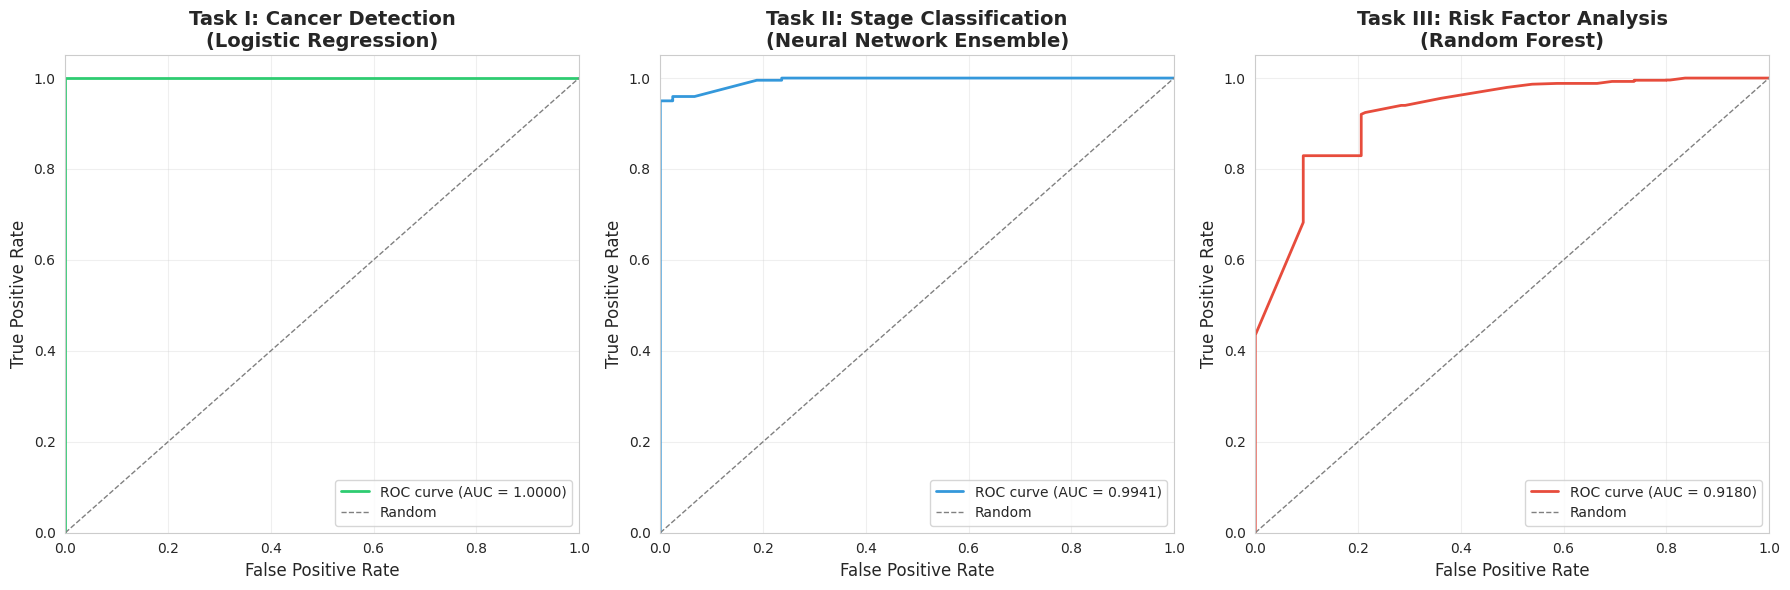


✅ ROC curves generated and saved!

Note: ROC curves use full-dataset feature selection for visualization.
Actual CV results use proper feature selection within each fold.


In [146]:
print("Generating ROC curves for all tasks...")
print("="*60)

# Import auc separately to avoid naming conflicts
from sklearn.metrics import auc as compute_auc

# Create figure with 1x3 subplots (3 tasks)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Get best model for Task III
best_model_task3 = max(task3_results.items(), key=lambda x: x[1]['accuracy'])[0]

# ============================================================================
# TASK I: Cancer Detection ROC
# ============================================================================
print("\n1. Generating Task I ROC curve...")
# Note: For visualization, we select features on full dataset
# Actual CV results use proper feature selection within each fold
train_df_full = pd.DataFrame(X_task1_full, columns=all_meth_samples.columns)
cpg_var_full = train_df_full.var()
top_cpgs_full = cpg_var_full.nlargest(500).index
X_task1_viz = train_df_full[top_cpgs_full].values

# Impute NaN
imputer_viz = SimpleImputer(strategy='mean')
X_task1_viz = imputer_viz.fit_transform(X_task1_viz)

lr_task1 = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_task1.fit(X_task1_viz, y_task1)
y_proba_task1 = lr_task1.predict_proba(X_task1_viz)[:, 1]
fpr_task1, tpr_task1, _ = roc_curve(y_task1, y_proba_task1)
roc_auc_task1 = np.mean(task1_results['auc_scores'])

axes[0].plot(fpr_task1, tpr_task1, color='#2ecc71', lw=2, 
                label=f'ROC curve (AUC = {roc_auc_task1:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Task I: Cancer Detection\n(Logistic Regression)', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# ============================================================================
# TASK II: Stage Classification ROC
# ============================================================================
print("2. Generating Task II ROC curve...")
# Prepare Task II data with pre-selected features for visualization
df_task2_viz = patient_df[patient_df['stage_binary'].notna()].copy()
mutation_cols_viz = [col for col in df_task2_viz.columns if col.startswith('mut_')]
expression_cols_viz = [col for col in df_task2_viz.columns if col.startswith('expr_')]
methylation_cols_viz = [col for col in df_task2_viz.columns if col.startswith('meth_')]

# Simple feature selection for visualization
mut_counts_viz = df_task2_viz[mutation_cols_viz].sum().sort_values(ascending=False)
expr_var_viz = df_task2_viz[expression_cols_viz].var().sort_values(ascending=False)
meth_var_viz = df_task2_viz[methylation_cols_viz].var().sort_values(ascending=False)

selected_viz = (mut_counts_viz.head(30).index.tolist() + 
                expr_var_viz.head(50).index.tolist() + 
                meth_var_viz.head(50).index.tolist())

X_task2_viz = df_task2_viz[selected_viz].fillna(0).values.astype(np.float32)
y_task2_viz = df_task2_viz['stage_binary'].values.astype(np.int64)

# Re-train ensemble to get probabilities
ensemble_preds = []
for model_idx in range(5):
    torch.manual_seed(RANDOM_SEED + model_idx)
    model = SimpleClassifier(X_task2_viz.shape[1], num_classes=2, dropout=0.5)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_task2_viz), y=y_task2_viz)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
    
    model.train()
    X_train_t = torch.FloatTensor(X_task2_viz)
    y_train_t = torch.LongTensor(y_task2_viz)
    
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_train_t)
        probs = torch.softmax(outputs, dim=1).numpy()
        ensemble_preds.append(probs)

avg_probs = np.mean(ensemble_preds, axis=0)
y_proba_task2 = avg_probs[:, 1]
fpr_task2, tpr_task2, _ = roc_curve(y_task2_viz, y_proba_task2)
roc_auc_task2 = compute_auc(fpr_task2, tpr_task2)

axes[1].plot(fpr_task2, tpr_task2, color='#3498db', lw=2, 
                label=f'ROC curve (AUC = {roc_auc_task2:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Task II: Stage Classification\n(Neural Network Ensemble)', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

# ============================================================================
# TASK III: Risk Factor Analysis ROC
# ============================================================================
print("3. Generating Task III ROC curve...")
if best_model_task3 == 'Logistic Regression':
    model_task3 = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED)
else:
    model_task3 = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=4, random_state=RANDOM_SEED)

model_task3.fit(X_task3, y_task3)
y_proba_task3 = model_task3.predict_proba(X_task3)[:, 1]
fpr_task3, tpr_task3, _ = roc_curve(y_task3, y_proba_task3)
roc_auc_task3 = task3_results[best_model_task3]['auc']

axes[2].plot(fpr_task3, tpr_task3, color='#e74c3c', lw=2, 
                label=f'ROC curve (AUC = {roc_auc_task3:.4f})')
axes[2].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontsize=12)
axes[2].set_ylabel('True Positive Rate', fontsize=12)
axes[2].set_title(f'Task III: Risk Factor Analysis\n({best_model_task3})', fontsize=14, fontweight='bold')
axes[2].legend(loc="lower right")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'roc_curves_all_tasks.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ROC curves generated and saved!")
print("\nNote: ROC curves use full-dataset feature selection for visualization.")
print("Actual CV results use proper feature selection within each fold.")